In [84]:


import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import glob
from IPython.display import display
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
from tqdm import tqdm_notebook
import random


# diretory of data
img_dir = [r"C:\Users\THOMA\Documents\Computer Science and Math\EIT UCA\Deep Learning\kaggle\data\training", 
           r"E:\data_science_competition\ds seminar\polytech-ds-2019\validation"]
# map number to label name
label_name = {i:category for i, category in enumerate(["Bread","Dairy products", "Dessert", "Egg",
                                                       "Fried Food",  "Meat", "Noodles/Pasta", "Rice",
                                                       "Seafood", "Soup", "Vegetable/Fruit"])}
length_data_in_trainingSet = len(glob.glob(img_dir[0]+"\*"))

label of 0_74.jpg (picture #10200) is Bread


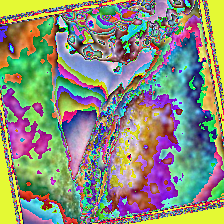

In [85]:
class trainDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir):
        super().__init__()
        self.img_dir = img_dir
        # use glob to get all image names
        self.img_names = [x.rsplit("\\")[-1] for _dir in img_dir for x in glob.glob(_dir + "/*") ]
        self.labels = [int(img.rsplit("_")[-2]) for img in self.img_names]

        # PyTorch transforms
        self.transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                             transforms.RandomRotation(180),
                                             transforms.ColorJitter(),
                                             # transforms.RandomRotation(45),
                                             # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                                             # transforms.Resize((448, 448)),
                                               transforms.Resize((224, 224)),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                            ])

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, i):
        return self._read_img(i)

    def _read_img(self, i):
        if i > length_data_in_trainingSet:
            ind = 1
        else:
            ind = 0
        img = Image.open(self.img_dir[ind] + "\\" + self.img_names[i])
        return self.transform(img), self.labels[i]

def display_tensor(t):
    trans = transforms.ToPILImage()
    display(trans(t))

ind = 10200
train_data = trainDataset(img_dir)
img, label = train_data[ind]
print("label of {} (picture #{}) is {}".format(train_data.img_names[ind], ind, label_name[label]))
display_tensor(img)

In [271]:
test_split = 0.1
val_split = 0.1
batch_size = 12

N_test_samples = round(test_split * len(train_data))
train_and_val_set, test_set = torch.utils.data.random_split(train_data, 
                                                            [len(train_data) - N_test_samples, N_test_samples])

N_val_samples = round(val_split * len(train_and_val_set))
train_set, val_set = torch.utils.data.random_split(train_and_val_set, 
                                                   [len(train_and_val_set) - N_val_samples, N_val_samples])

N_pretrain_samples = round(0.075 * len(train_set))
_,pretrain_set = torch.utils.data.random_split(train_set,[len(train_set) - N_pretrain_samples, N_pretrain_samples])

train_dl = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
pretrain_dl = torch.utils.data.DataLoader(pretrain_set, batch_size=batch_size,shuffle=True)

In [272]:
len(pretrain_set)

808

# Truely pretrain

In [273]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [153]:
resnet50 = models.resnet50(pretrained=True)
set_parameter_requires_grad(resnet50, True)
fc_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(fc_features, 11)

torch.cuda.empty_cache()
LEARNING_RATE = 0.001
net = resnet50
net = net.cuda()

hasParams = False
if hasParams:
    net.load_state_dict(torch.load('benchmark_model_resnet50_params.pkl')) # we already pre-train several epoch

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [154]:
N_EPOCHS = 20
epoch_val_loss = [] 
epoch_val_acc = []
epoch_train_loss = []
epoch_train_acc = []
best_val_acc = 0
flag = 0
for e in range(N_EPOCHS):
    print("EPOCH:",e)
  
    ### TRAINING LOOP
    running_loss = 0
    running_accuracy = 0
  
    ## Put the network in training mode
    net.train()
  
    for i, batch in enumerate(tqdm_notebook(pretrain_dl)):
        # Get a batch from the dataloader
        x = batch[0]
        labels = batch[1]
        # move the batch to GPU
        x = x.cuda()
        labels = labels.cuda()

        # Compute the network output
        y = net(x)
        loss = criterion(y, labels)
        optimizer.zero_grad()
        loss.backward()
        # Apply one step of the descent algorithm to update the weights
        optimizer.step()
    
        ## Compute some statistics
        running_loss += loss.item()
        running_accuracy += (y.max(1)[1] == labels).sum().item()
    print("Training accuracy: {:.2f}%".format(100*running_accuracy/float(len(pretrain_set))),
          "Training loss:", running_loss/float(len(pretrain_set)))
    epoch_train_acc.append(running_loss)
    epoch_train_loss.append(running_accuracy)

EPOCH: 0


A Jupyter Widget

Training accuracy: 35.15% Training loss: 0.16177857807367155
EPOCH: 1


A Jupyter Widget

Training accuracy: 59.16% Training loss: 0.11039427557204029
EPOCH: 2


A Jupyter Widget

Training accuracy: 66.83% Training loss: 0.08834249216436159
EPOCH: 3


A Jupyter Widget

Training accuracy: 70.30% Training loss: 0.07697599536121481
EPOCH: 4


A Jupyter Widget

Training accuracy: 69.93% Training loss: 0.07671184384144179
EPOCH: 5


A Jupyter Widget

Training accuracy: 71.29% Training loss: 0.07127872946681363
EPOCH: 6


A Jupyter Widget

Training accuracy: 75.99% Training loss: 0.06272433004756965
EPOCH: 7


A Jupyter Widget

Training accuracy: 74.01% Training loss: 0.06356628980524469
EPOCH: 8


A Jupyter Widget

Training accuracy: 77.35% Training loss: 0.05638875391813788
EPOCH: 9


A Jupyter Widget

Training accuracy: 76.86% Training loss: 0.060284106245282854
EPOCH: 10


A Jupyter Widget

Training accuracy: 77.60% Training loss: 0.05320041637757037
EPOCH: 11


A Jupyter Widget

Training accuracy: 78.34% Training loss: 0.05448054868986111
EPOCH: 12


A Jupyter Widget

Training accuracy: 78.71% Training loss: 0.05578240385223733
EPOCH: 13


A Jupyter Widget

Training accuracy: 80.32% Training loss: 0.0519752927530225
EPOCH: 14


A Jupyter Widget

Training accuracy: 78.59% Training loss: 0.052717570528978165
EPOCH: 15


A Jupyter Widget

Training accuracy: 77.60% Training loss: 0.05177611018540246
EPOCH: 16


A Jupyter Widget

Training accuracy: 79.46% Training loss: 0.05060470561579902
EPOCH: 17


A Jupyter Widget

Training accuracy: 79.95% Training loss: 0.04733980548485081
EPOCH: 18


A Jupyter Widget

Training accuracy: 83.29% Training loss: 0.04300823425966324
EPOCH: 19


A Jupyter Widget

Training accuracy: 81.68% Training loss: 0.04512816070034952


In [155]:
N_EPOCHS = 100
epoch_val_loss = [] 
epoch_val_acc = []
epoch_train_loss = []
epoch_train_acc = []
best_val_acc = 0
flag = 0
for e in range(N_EPOCHS):
    print("EPOCH:",e)
  
    ### TRAINING LOOP
    running_loss = 0
    running_accuracy = 0
  
    ## Put the network in training mode
    net.train()
  
    for i, batch in enumerate(tqdm_notebook(train_dl)):
        # Get a batch from the dataloader
        x = batch[0]
        labels = batch[1]
        # move the batch to GPU
        x = x.cuda()
        labels = labels.cuda()

        # Compute the network output
        y = net(x)
        loss = criterion(y, labels)
        optimizer.zero_grad()
        loss.backward()
        # Apply one step of the descent algorithm to update the weights
        optimizer.step()
    
        ## Compute some statistics
        running_loss += loss.item()
        running_accuracy += (y.max(1)[1] == labels).sum().item()
    print("Training accuracy: {:.2f}%".format(100*running_accuracy/float(len(train_set))),
          "Training loss:", running_loss/float(len(train_set)))

    epoch_train_acc.append(running_accuracy/float(len(train_set)))
    epoch_train_loss.append(running_loss/float(len(train_set)))
    
    ### VALIDATION LOOP
    net.eval()

    running_val_loss = 0
    running_val_accuracy = 0
    
    for i, batch in enumerate(val_dl):
        with torch.no_grad():
            # Get a batch from the dataloader
            x = batch[0]
            labels = batch[1]
            x = x.cuda()
            labels = labels.cuda()

            # Compute the network output
            y = net(x)
            loss = criterion(y, labels)

            running_val_loss += loss.item()
            running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    acc = running_val_accuracy/float(len(val_set))
    if e > 30:
        if acc > best_val_acc:
            best_val_acc = acc
            torch.save(net.state_dict(), 'benchmark_model_resnet50_params.pkl')
            flag = 0
        else:
            flag += 1
            if flag >= 10:
                print("Oops!")
                break
    print("Validation accuracy:{:.2f}%".format(100* acc),
          "Validation loss:", running_val_loss/float(len(val_set)))
    epoch_val_loss.append(running_val_loss/len(val_set))
    epoch_val_acc.append(running_val_accuracy/len(val_set))

EPOCH: 0


A Jupyter Widget

Training accuracy: 72.62% Training loss: 0.07079636914990596
Validation accuracy:76.27% Validation loss: 0.06462620273419191
EPOCH: 1


A Jupyter Widget

Training accuracy: 74.89% Training loss: 0.06395216526809382
Validation accuracy:78.61% Validation loss: 0.05689364080702452
EPOCH: 2


A Jupyter Widget

Training accuracy: 75.11% Training loss: 0.06308820045123592
Validation accuracy:77.61% Validation loss: 0.05592431073872965
EPOCH: 3


A Jupyter Widget

Training accuracy: 75.88% Training loss: 0.06224607607912404
Validation accuracy:75.94% Validation loss: 0.06581296845834855
EPOCH: 4


A Jupyter Widget

Training accuracy: 76.86% Training loss: 0.05981364036552288
Validation accuracy:78.11% Validation loss: 0.06069118048102535
EPOCH: 5


A Jupyter Widget

Training accuracy: 76.65% Training loss: 0.05944081162674943
Validation accuracy:74.77% Validation loss: 0.06121612897916147
EPOCH: 6


A Jupyter Widget

Training accuracy: 77.03% Training loss: 0.05765522476910095
Validation accuracy:80.53% Validation loss: 0.05243217626410718
EPOCH: 7


A Jupyter Widget

Training accuracy: 77.41% Training loss: 0.05748193508778755
Validation accuracy:79.53% Validation loss: 0.054101733794263134
EPOCH: 8


A Jupyter Widget

Training accuracy: 77.81% Training loss: 0.05590409454283791
Validation accuracy:79.03% Validation loss: 0.05802289309694355
EPOCH: 9


A Jupyter Widget

Training accuracy: 77.56% Training loss: 0.05862813495388048
Validation accuracy:79.70% Validation loss: 0.05431524908314821
EPOCH: 10


A Jupyter Widget

Training accuracy: 78.55% Training loss: 0.05498118571909756
Validation accuracy:77.11% Validation loss: 0.06655641132771171
EPOCH: 11


A Jupyter Widget

Training accuracy: 78.59% Training loss: 0.0549110601482224
Validation accuracy:79.45% Validation loss: 0.05701966154091091
EPOCH: 12


A Jupyter Widget

Training accuracy: 78.01% Training loss: 0.05500454891516988
Validation accuracy:82.21% Validation loss: 0.04920622396906067
EPOCH: 13


A Jupyter Widget

Training accuracy: 78.14% Training loss: 0.05522723818779523
Validation accuracy:79.78% Validation loss: 0.05419424429781729
EPOCH: 14


A Jupyter Widget

Training accuracy: 78.56% Training loss: 0.054472565942556596
Validation accuracy:79.37% Validation loss: 0.05359237153260481
EPOCH: 15


A Jupyter Widget

Training accuracy: 79.24% Training loss: 0.05307633071376447
Validation accuracy:79.95% Validation loss: 0.056319278001212635
EPOCH: 16


A Jupyter Widget

Training accuracy: 78.91% Training loss: 0.053857690913189156
Validation accuracy:80.70% Validation loss: 0.054138783387273376
EPOCH: 17


A Jupyter Widget

Training accuracy: 78.96% Training loss: 0.05351251016547116
Validation accuracy:80.70% Validation loss: 0.05246223746693896
EPOCH: 18


A Jupyter Widget

Training accuracy: 79.14% Training loss: 0.05312020496351715
Validation accuracy:79.70% Validation loss: 0.05487973158346581
EPOCH: 19


A Jupyter Widget

Training accuracy: 79.28% Training loss: 0.05170799431287541
Validation accuracy:79.53% Validation loss: 0.054390759776060844
EPOCH: 20


A Jupyter Widget

Training accuracy: 79.34% Training loss: 0.051477710187676606
Validation accuracy:81.45% Validation loss: 0.04836703590588114
EPOCH: 21


A Jupyter Widget

Training accuracy: 79.26% Training loss: 0.052104093773849704
Validation accuracy:81.29% Validation loss: 0.04979780987963242
EPOCH: 22


A Jupyter Widget

Training accuracy: 79.63% Training loss: 0.05186543348155814
Validation accuracy:78.61% Validation loss: 0.0609730839349622
EPOCH: 23


A Jupyter Widget

Training accuracy: 79.54% Training loss: 0.05257897448562288
Validation accuracy:82.12% Validation loss: 0.04838908825041656
EPOCH: 24


A Jupyter Widget

Training accuracy: 79.59% Training loss: 0.052228573249816085
Validation accuracy:80.37% Validation loss: 0.05247258720180345
EPOCH: 25


A Jupyter Widget

Training accuracy: 79.65% Training loss: 0.051542808732685685
Validation accuracy:80.53% Validation loss: 0.04994337993021199
EPOCH: 26


A Jupyter Widget

Training accuracy: 79.98% Training loss: 0.050633934887996265
Validation accuracy:79.28% Validation loss: 0.05774774327920867
EPOCH: 27


A Jupyter Widget

Training accuracy: 80.64% Training loss: 0.049854532850368165
Validation accuracy:82.21% Validation loss: 0.04844233012737188
EPOCH: 28


A Jupyter Widget

Training accuracy: 80.11% Training loss: 0.04941216841072317
Validation accuracy:80.79% Validation loss: 0.049590477293533095
EPOCH: 29


A Jupyter Widget

Training accuracy: 80.67% Training loss: 0.04947547147996438
Validation accuracy:81.20% Validation loss: 0.051109284246550465
EPOCH: 30


A Jupyter Widget

Training accuracy: 80.41% Training loss: 0.04922061097867941
Validation accuracy:80.03% Validation loss: 0.05516156359399072
EPOCH: 31


A Jupyter Widget

Training accuracy: 80.43% Training loss: 0.050208972617035975
Validation accuracy:80.28% Validation loss: 0.05248627665864246
EPOCH: 32


A Jupyter Widget

Training accuracy: 80.69% Training loss: 0.050256928620218806
Validation accuracy:80.87% Validation loss: 0.053078050536096544
EPOCH: 33


A Jupyter Widget

Training accuracy: 80.18% Training loss: 0.049664019148135036
Validation accuracy:76.11% Validation loss: 0.07478769529383683
EPOCH: 34


A Jupyter Widget

Training accuracy: 80.77% Training loss: 0.04881516509712827
Validation accuracy:80.62% Validation loss: 0.05619676124091348
EPOCH: 35


A Jupyter Widget

Training accuracy: 80.12% Training loss: 0.0502344342117268
Validation accuracy:81.79% Validation loss: 0.05255757287493226
EPOCH: 36


A Jupyter Widget

Training accuracy: 80.74% Training loss: 0.04883112939594737
Validation accuracy:80.70% Validation loss: 0.0534284976805088
EPOCH: 37


A Jupyter Widget

Training accuracy: 81.05% Training loss: 0.049092120976736535
Validation accuracy:81.62% Validation loss: 0.051005602629859946
EPOCH: 38


A Jupyter Widget

Training accuracy: 81.12% Training loss: 0.0484978482258642
Validation accuracy:78.45% Validation loss: 0.0578945465914986
EPOCH: 39


A Jupyter Widget

Training accuracy: 81.74% Training loss: 0.0471162008581174
Validation accuracy:80.95% Validation loss: 0.0547336912188763
EPOCH: 40


A Jupyter Widget

Training accuracy: 81.22% Training loss: 0.0479678063672349
Validation accuracy:81.54% Validation loss: 0.051604745249787566
EPOCH: 41


A Jupyter Widget

Training accuracy: 81.47% Training loss: 0.04699161003803585
Validation accuracy:81.87% Validation loss: 0.04940621619273845
EPOCH: 42


A Jupyter Widget

Training accuracy: 80.67% Training loss: 0.04890693715299689
Validation accuracy:79.87% Validation loss: 0.05296304968863402
EPOCH: 43


A Jupyter Widget

Training accuracy: 81.88% Training loss: 0.0456231596274029
Validation accuracy:82.12% Validation loss: 0.04822038716901912
EPOCH: 44


A Jupyter Widget

Training accuracy: 81.47% Training loss: 0.04646788202160436
Validation accuracy:78.45% Validation loss: 0.06094472099690011
EPOCH: 45


A Jupyter Widget

Training accuracy: 81.18% Training loss: 0.04794770904139275
Validation accuracy:80.87% Validation loss: 0.05246289048278541
EPOCH: 46


A Jupyter Widget

Training accuracy: 81.35% Training loss: 0.047627181981728536
Validation accuracy:81.37% Validation loss: 0.05061992577766516
EPOCH: 47


A Jupyter Widget

Training accuracy: 81.24% Training loss: 0.04810185509807625
Validation accuracy:77.36% Validation loss: 0.061931479781393024
EPOCH: 48


A Jupyter Widget

Training accuracy: 81.58% Training loss: 0.046972919107784145
Validation accuracy:80.03% Validation loss: 0.05331927389933501
EPOCH: 49


A Jupyter Widget

Training accuracy: 81.57% Training loss: 0.047120910630146215
Validation accuracy:80.79% Validation loss: 0.052816347103120886
EPOCH: 50


A Jupyter Widget

Training accuracy: 81.80% Training loss: 0.04592803923389115
Validation accuracy:81.62% Validation loss: 0.05007095600236378
EPOCH: 51


A Jupyter Widget

Training accuracy: 81.33% Training loss: 0.0466608739054068
Validation accuracy:79.95% Validation loss: 0.05549535576219895
EPOCH: 52


A Jupyter Widget

Training accuracy: 82.15% Training loss: 0.046335351088757366
Validation accuracy:81.20% Validation loss: 0.05272563594823692
EPOCH: 53


A Jupyter Widget

Training accuracy: 82.26% Training loss: 0.0442601132564394
Oops!


In [156]:
# accuracy on test set
net.load_state_dict(torch.load('benchmark_model_resnet50_params.pkl'))
net.eval()
running_test_accuracy = 0
for i, batch in enumerate(test_dl):
    with torch.no_grad():
        x = batch[0]
        labels = batch[1]
        x = x.cuda()
        x = x.cuda()
        labels = labels.cuda()
        y = net(x)
        running_test_accuracy += (y.max(1)[1] == labels).sum().item()
print("Test accuracy:{:.2f}%".format(100* running_test_accuracy/float(len(test_set))))
# Test accuracy:84.81%
# Test accuracy:85.11% train longer

Test accuracy:85.11%


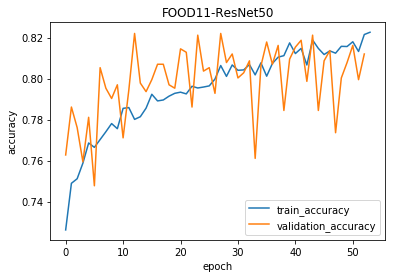

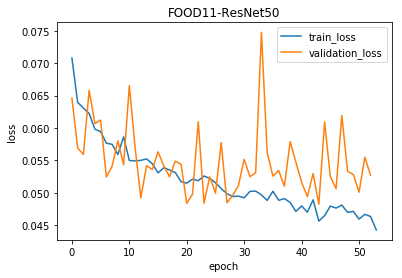

In [157]:
import matplotlib.pyplot as plt
def plot_accuracy(train_acc, val_acc):
    plt.title('FOOD11-ResNet50')
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(train_loss, val_loss):
    plt.title('FOOD11-ResNet50')
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

    
plot_accuracy(epoch_train_acc, epoch_val_acc) 
plot_loss(epoch_train_loss, epoch_val_loss)

In [158]:
# accuracy on test set
net.eval()
running_test_accuracy = 0
for i in range(len(test_set)):
    with torch.no_grad():
        x = torch.cat([test_set[i][0].unsqueeze(0) for _ in range(10)], 0)
        labels = test_set[i][1]
        x = x.cuda()
        labels = (torch.tensor(labels)).cuda()
        y = net(x)
        running_test_accuracy += ((y.max(1)[1]).mode()[0] == labels).item()
print("Test accuracy:{:.2f}%".format(100* running_test_accuracy/float(len(test_set))))
# Test accuracy:87.14%
# Test accuracy:88.05% train longer

Test accuracy:88.05%


# pretrain v2

In [92]:
test_split = 0.1
batch_size = 12
N_EPOCHS = 50

N_test_samples = round(test_split * len(train_data))
train_set, val_set = torch.utils.data.random_split(train_data,[len(train_data) - N_test_samples, N_test_samples])


N_pretrain_samples = round(0.075 * len(train_set))
_,pretrain_set = torch.utils.data.random_split(train_set,[len(train_set) - N_pretrain_samples, N_pretrain_samples])

train_dl = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
pretrain_dl = torch.utils.data.DataLoader(pretrain_set, batch_size=batch_size,shuffle=True)





In [88]:
batch_size = 12

train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)

In [93]:
"""
(2): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
"""
def print_if_requires_grad(model, feature_extracting):
    i = 0
    for param in enumerate(model.parameters()):
        i += 1
    if feature_extracting:
        for param in model.parameters():
            print(param.requires_grad)
            

            
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [94]:
resnet50 = models.resnet152(pretrained=True)
set_parameter_requires_grad(resnet50, True)
fc_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(fc_features, 11)
print(resnet50)

next(resnet50.layer4[1].conv1.parameters()).requires_grad = True
next(resnet50.layer4[1].conv2.parameters()).requires_grad = True
next(resnet50.layer4[1].conv3.parameters()).requires_grad = True

next(resnet50.layer4[2].conv1.parameters()).requires_grad = True
next(resnet50.layer4[2].conv2.parameters()).requires_grad = True
next(resnet50.layer4[2].conv3.parameters()).requires_grad = True


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

)


In [95]:
torch.cuda.empty_cache()
LEARNING_RATE = 0.001
net = resnet50
net = net.cuda()
N_EPOCHS = 50

hasParams = False
if hasParams:
    net.load_state_dict(torch.load('benchmark_model_resnext101_32x8d.pkl')) # we already pre-train several epoch

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

optimizer = torch.optim.SGD(net.parameters(),lr = LEARNING_RATE, momentum=0.9,weight_decay=1e-4) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = (N_EPOCHS // 9) + 1)

In [ ]:
epoch_val_loss = [] 
epoch_val_acc = []
epoch_train_loss = []
epoch_train_acc = []
best_val_acc = 0
flag = 0
for e in range(N_EPOCHS):
    print("EPOCH:",e)
  
    ### TRAINING LOOP
    running_loss = 0
    running_accuracy = 0
  
    ## Put the network in training mode
    net.train()
    
      
    for i, batch in enumerate(tqdm_notebook(train_dl)):
        # Get a batch from the dataloader
        x = batch[0]
        labels = batch[1]
        # move the batch to GPU
        x = x.cuda()
        labels = labels.cuda()

        # Compute the network output
        y = net(x)
        loss = criterion(y, labels)
        optimizer.zero_grad()
        loss.backward()
        # Apply one step of the descent algorithm to update the weights
        optimizer.step()
        scheduler.step(e)
        ## Compute some statistics
        running_loss += loss.item()
        running_accuracy += (y.max(1)[1] == labels).sum().item()
    print("Training accuracy: {:.2f}%".format(100*running_accuracy/float(len(train_set))),
          "Training loss:", running_loss/float(len(train_set)))

    epoch_train_acc.append(running_accuracy/float(len(train_set)))
    epoch_train_loss.append(running_loss/float(len(train_set)))
    
    ### VALIDATION LOOP
    net.eval()

    running_val_loss = 0
    running_val_accuracy = 0
    
    for i, batch in enumerate(val_dl):
        with torch.no_grad():
            # Get a batch from the dataloader
            x = batch[0]
            labels = batch[1]
            x = x.cuda()
            labels = labels.cuda()

            # Compute the network output
            y = net(x)
            loss = criterion(y, labels)

            running_val_loss += loss.item()
            running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    acc = running_val_accuracy/float(len(val_set))
    if e > 20:
        if acc > best_val_acc:
            best_val_acc = acc
            torch.save(net.state_dict(), 'benchmark_model_resnet__params.pkl')
            flag = 0
        else:
            flag += 1
            if flag >= 10:
                print("Oops!")
                break
    print("Validation accuracy:{:.2f}%".format(100* acc),
          "Validation loss:", running_val_loss/float(len(val_set)))
    epoch_val_loss.append(running_val_loss/len(val_set))
    epoch_val_acc.append(running_val_accuracy/len(val_set))

EPOCH: 0


A Jupyter Widget

Training accuracy: 70.22% Training loss: 0.07552590420288763
Validation accuracy:80.98% Validation loss: 0.046462498638862954
EPOCH: 1


A Jupyter Widget

Training accuracy: 81.50% Training loss: 0.04805057812074286
Validation accuracy:83.91% Validation loss: 0.043665537487407376
EPOCH: 2


A Jupyter Widget

Training accuracy: 84.21% Training loss: 0.03986802198348955
Validation accuracy:86.84% Validation loss: 0.03697221649152444
EPOCH: 3


A Jupyter Widget

Training accuracy: 85.09% Training loss: 0.03803867968205582
Validation accuracy:85.79% Validation loss: 0.03649943149403522
EPOCH: 4


A Jupyter Widget

Training accuracy: 85.42% Training loss: 0.036724495557504976
Validation accuracy:86.54% Validation loss: 0.03436129020835112
EPOCH: 5


A Jupyter Widget

Training accuracy: 84.78% Training loss: 0.03892982807854097
Validation accuracy:85.19% Validation loss: 0.037357522629873643
EPOCH: 6


A Jupyter Widget

Training accuracy: 85.33% Training loss: 0.037032694200443896
Validation accuracy:87.52% Validation loss: 0.03259447259002162
EPOCH: 7


A Jupyter Widget

Training accuracy: 86.89% Training loss: 0.032779966921240626
Validation accuracy:87.44% Validation loss: 0.033524617385399295
EPOCH: 8


A Jupyter Widget

Training accuracy: 88.78% Training loss: 0.027586657592593083
Validation accuracy:89.55% Validation loss: 0.029494941946035042
EPOCH: 9


A Jupyter Widget

Training accuracy: 89.90% Training loss: 0.025234884916898594
Validation accuracy:88.50% Validation loss: 0.030014566840127783
EPOCH: 10


A Jupyter Widget

Training accuracy: 89.55% Training loss: 0.025067469689711123
Validation accuracy:88.35% Validation loss: 0.028565605950394743
EPOCH: 11


A Jupyter Widget

Training accuracy: 88.60% Training loss: 0.028023282051549987
Validation accuracy:87.07% Validation loss: 0.03630011687230291
EPOCH: 12


A Jupyter Widget

Training accuracy: 88.53% Training loss: 0.02820223956552544
Validation accuracy:88.20% Validation loss: 0.032336832912064586
EPOCH: 13


A Jupyter Widget

Training accuracy: 89.29% Training loss: 0.02553921175831731
Validation accuracy:88.50% Validation loss: 0.03152374932866305
EPOCH: 14


A Jupyter Widget

Training accuracy: 91.92% Training loss: 0.020204096587666517
Validation accuracy:89.02% Validation loss: 0.029560309776308056
EPOCH: 15


A Jupyter Widget

Training accuracy: 92.36% Training loss: 0.018708319048556486
Validation accuracy:88.87% Validation loss: 0.03032648548294783
EPOCH: 16


A Jupyter Widget

Training accuracy: 92.25% Training loss: 0.01927017340189543
Validation accuracy:90.68% Validation loss: 0.026801237354013033
EPOCH: 17


A Jupyter Widget

In [ ]:
import matplotlib.pyplot as plt
def plot_accuracy(train_acc, val_acc):
    plt.title('FOOD11-ResNet50')
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(train_loss, val_loss):
    plt.title('FOOD11-ResNet50')
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

    
plot_accuracy(epoch_train_acc, epoch_val_acc) 
plot_loss(epoch_train_loss, epoch_val_loss)

In [ ]:
# accuracy on test set
# net.load_state_dict(torch.load('benchmark_model_resnet50_params.pkl'))
net.eval()
running_test_accuracy = 0
for i, batch in enumerate(val_dl):
    with torch.no_grad():
        x = batch[0]
        labels = batch[1]
        x = x.cuda()
        x = x.cuda()
        labels = labels.cuda()
        y = net(x)
        running_test_accuracy += (y.max(1)[1] == labels).sum().item()
print("Test accuracy:{:.2f}%".format(100* running_test_accuracy/float(len(val_set))))
# Test accuracy:84.81%
# Test accuracy:85.11% train longer
# Test accuracy:88.72% train the last 4 layers
# Test accuracy:89.02% train the last 4 layers & new argument
# Test accuracy:91.25% train the last 4 layers & ResNext

In [ ]:
# accuracy on test set
net.eval()
running_test_accuracy = 0
for i in range(len(val_set)):
    with torch.no_grad():
        x = torch.cat([val_set[i][0].unsqueeze(0) for _ in range(10)], 0)
        labels = val_set[i][1]
        x = x.cuda()
        labels = (torch.tensor(labels)).cuda()
        y = net(x)
        running_test_accuracy += ((y.max(1)[1]).mode()[0] == labels).item()
print("Test accuracy:{:.2f}%".format(100* running_test_accuracy/float(len(val_set))))
# Test accuracy:87.14%
# Test accuracy:88.05% train longer
# Test accuracy:89.40% train the last 4 layers
# Test accuracy:92.26% train the last 4 layers & new argument
# Test accuracy:93.11% train the last 4 layers & ResNext

In [82]:
# diretory of data
res_img_dir = "E:\data_science_competition\ds seminar\polytech-ds-2019\kaggle_evaluation"
class testDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir):
        super().__init__()
        self.img_dir = img_dir
        # use glob to get all image names
        self.img_names = [x.rsplit("\\")[-1] for x in glob.glob(img_dir + "\*") ]
        
        # PyTorch transforms
        self.transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                             transforms.RandomRotation(180),
                                             transforms.ColorJitter(),
                                             # transforms.RandomRotation(45),
                                             # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                                             # transforms.Resize((448, 448)),
                                               transforms.Resize((224, 224)),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                            ])
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, i):
        return self._read_img(i)

    def _read_img(self, i):
        img = Image.open(self.img_dir + "\\" + self.img_names[i])
        return self.transform(img), self.img_names[i]
    

In [83]:
import pandas as pd
import numpy as np
res_test_dataset = testDataset(res_img_dir)
net.eval()

with open('sample_submission.csv', "w") as f:
    f.write("Id,Category\n")
    for i in range(len(res_test_dataset)):
        with torch.no_grad():
            x = torch.cat([res_test_dataset[i][0].unsqueeze(0) for _ in range(20)], 0)
            filename = res_test_dataset[i][1]
            x = x.cuda()
            y = net(x)
            f.write("{}, {:d}\n".format((filename.split("."))[0], ((y.max(1)[1]).mode()[0]).item()))
            # data_to_submit.iloc[i,0] = (filename.split("."))[0]
            # data_to_submit.iloc[i,1] = int()

In [86]:
torch.save(net.state_dict(), 'benchmark_model_resnet50_params.pkl')

In [ ]:
epoch_val_loss = [] 
epoch_val_acc = []
epoch_train_loss = []
epoch_train_acc = []
best_val_acc = 0
flag = 0
for e in range(N_EPOCHS):
    print("EPOCH:",e)
  
    ### TRAINING LOOP
    running_loss = 0
    running_accuracy = 0
  
    ## Put the network in training mode
    net.train()
    
      
    for i, batch in enumerate(tqdm_notebook(train_dl)):
        # Get a batch from the dataloader
        x = batch[0]
        labels = batch[1]
        # move the batch to GPU
        x = x.cuda()
        labels = labels.cuda()

        # Compute the network output
        y = net(x)
        loss = criterion(y, labels)
        optimizer.zero_grad()
        loss.backward()
        # Apply one step of the descent algorithm to update the weights
        optimizer.step()
        scheduler.step(e)
        ## Compute some statistics
        running_loss += loss.item()
        running_accuracy += (y.max(1)[1] == labels).sum().item()
    print("Training accuracy: {:.2f}%".format(100*running_accuracy/float(len(train_data))),
          "Training loss:", running_loss/float(len(train_data)))

    epoch_train_acc.append(running_accuracy/float(len(train_data)))
    epoch_train_loss.append(running_loss/float(len(train_data)))